# Read API v3.2 OCR Tester

## 1. Read API の実行

光学式文字認識（OCR）は、画像内のテキストを検出し、認識された文字を機械で使用可能な文字列として抽出します。<br>
成功すると、OCR の結果が返されます。

Read API v3.2 の定義書は[こちら](https://centraluseuap.dev.cognitive.microsoft.com/docs/services/computer-vision-v3-2/operations/56f91f2e778daf14a499f20d)を参照してください。

`subscription_key` と `endpoint` にご自分の Computer Vision サービスの情報を入力します。

In [7]:
import json
import requests
import time 
import codecs
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
imFilePath = './wagahaiwa_nekodearu.png'
with open(imFilePath, 'rb') as f:
    data = f.read()

#https://{endpoint}/vision/v3.2/read/analyze[?language][&pages][&readingOrder][&model-version]

subscription_key = "<your-subscription-key>"
endpoint = "https:/<your-service-name>.cognitiveservices.azure.com/"
text_recognition_url = endpoint + "vision/v3.2/read/analyze"
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type':'application/octet-stream'  }
params   = { 'language ': 'ja',
             'model-version':'2021-04-12'}

# 指定した画像の read メソッドを呼び出します。これによって操作 ID が返され、画像の内容を読み取る非同期プロセスが開始されます
response = requests.post(text_recognition_url, headers=headers, params=params, json=None, data=data)
response.raise_for_status()

# レスポンスから operation location（末尾にIDが付いたURL）を取得する
operation_url = response.headers["Operation-Location"]
analysis = {}
poll = True

# read の呼び出しから返された operation location ID を取得し、操作の結果をサービスに照会します。 
# 次のコードは、結果が返されるまで 1 秒間隔で操作をチェックします
while (poll):
    response_final = requests.get(response.headers["Operation-Location"], headers=headers)
    analysis = response_final.json()

    print(json.dumps(analysis, indent=4, ensure_ascii=False))

    time.sleep(1)
    if ("analyzeResult" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'failed'):
        poll = False

# JSON ファイルを出力
with codecs.open('output_read3.2.json', 'w+', 'utf-8') as fp:
    json.dump(analysis, fp, ensure_ascii=False, indent=2)

## 2. 認識結果の評価（行情報の取得）

認識結果の JSON ファイルを読み込んで、結果をパースした後、画像データ上に結果を描画します。

0: 吾輩は猫である
1: 夏目漱石
2: +目次
3: わがはい
4: 吾 輩は猫である。名前はまだ無い。
5: けんとう
6: どこで生れたかとんと見 当がつかぬ。何でも薄暗いじめじめした所でニヤー
7: ニャー泣いていた事だけは記憶している。吾輩はここで始めて人間というもの
8: どうあく
9: を見た。しかもあとで聞くとそれは書生という人間中で一番獰 悪な種族であっ
10: つかま
11: に
12: たそうだ。この書生というのは時々我々を捕えて煮て食うという話である。し
13: かしその当時は何という考もなかったから別段恐しいとも思わなかった。ただ
14: てのひら
15: 彼の 掌 に載せられてスーと持ち上げられた時何だかフワフワした感じがあっ
16: たばかりである。掌の上で少し落ちついて書生の顔を見たのがいわゆる人間と
17: みはじめ
18: いうものの見始であろう。この時妙なものだと思った感じが今でも残ってい
19: やかん
20: る。第一毛をもって装飾されべきはずの顔がつるつるしてまるで薬缶だ。その
21: ご
22: あ
23: かたわ
24: でく
25: 後猫にもだいぶ逢ったがこんな片輪には一度も出会わした事がない。のみなら
26: ず顔の真中があまりに突起している。そうしてその穴の中から時々ぷうぷうと
27: けむり
28: む
29: たばこ
30: 煙を吹く。どうも咽せぽくて実に弱った。これが人間の飲む煙草というもので
31: ある事はようやくこの頃知った。
32: うち
33: この書生の掌の裏でしばらくはよい心持に坐っておったが、しばらくすると
34: 非常な速力で運転し始めた。書生が動くのか自分だけが動くのか分らないが
35: むやみ
36: とうてい
37: 無暗に眼が廻る。胸が悪くなる。到底助からないと思っていると、どさりと音
38: がして眼から火が出た。それまでは記憶しているがあとは何の事やらいくら考
39: え出そうとしても分らない。
40: ぴき
41: ふと気が付いて見ると書生はいない。たくさんおった兄弟が一定も見えぬ。
42: かんじん
43: いま
44: むやみ
45: 肝 心の母親さえ姿を隠してしまった。その上今までの所とは違って無暗に明る



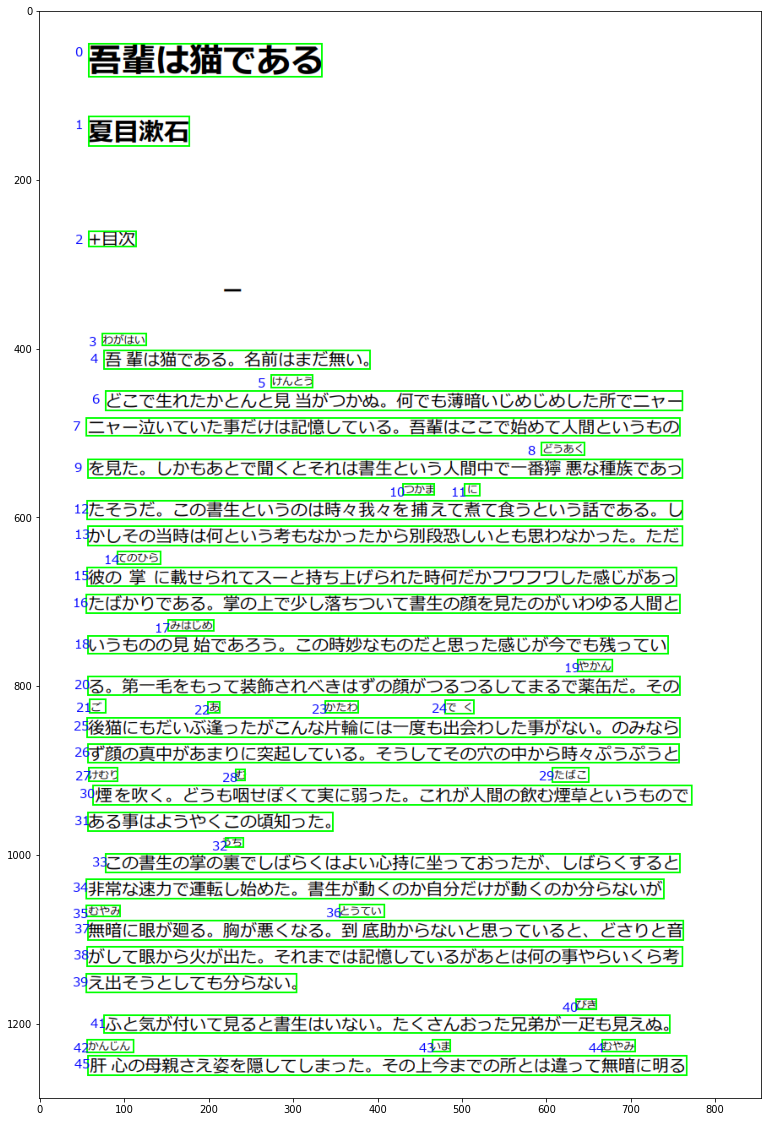

In [5]:

with open('./output_read3.2.json', 'r', encoding='utf-8') as f:
    analysis = json.load(f)
    
im = Image.open('wagahaiwa_nekodearu.png')
draw = ImageDraw.Draw(im)
fnt = ImageFont.truetype('./meiryo.ttc', 15) #描画用日本語フォントファイル名を指定

count = 0
lines = []
output = ""
if ("analyzeResult" in analysis):
    lines = [(line["boundingBox"], line["text"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]

    for line in lines:
        p = line[0]
        text = line[1]
        
        draw.rectangle([p[0], p[1], p[4], p[5]], fill=None, outline=(0, 255, 0),  width=2)
        draw.text((p[0] - 15, p[1]), str(count), font=fnt, fill=(0, 0, 255))
        output += str(count) + ": " + text
        output += '\n'
        count += 1

print(output)

plt.figure(figsize=(20, 20))
plt.imshow(np.array(im))

# 画像として出力
#im.save("./output_read3.2_line_result.png")

## 3. 認識結果の評価（文字単位）

lines:  46


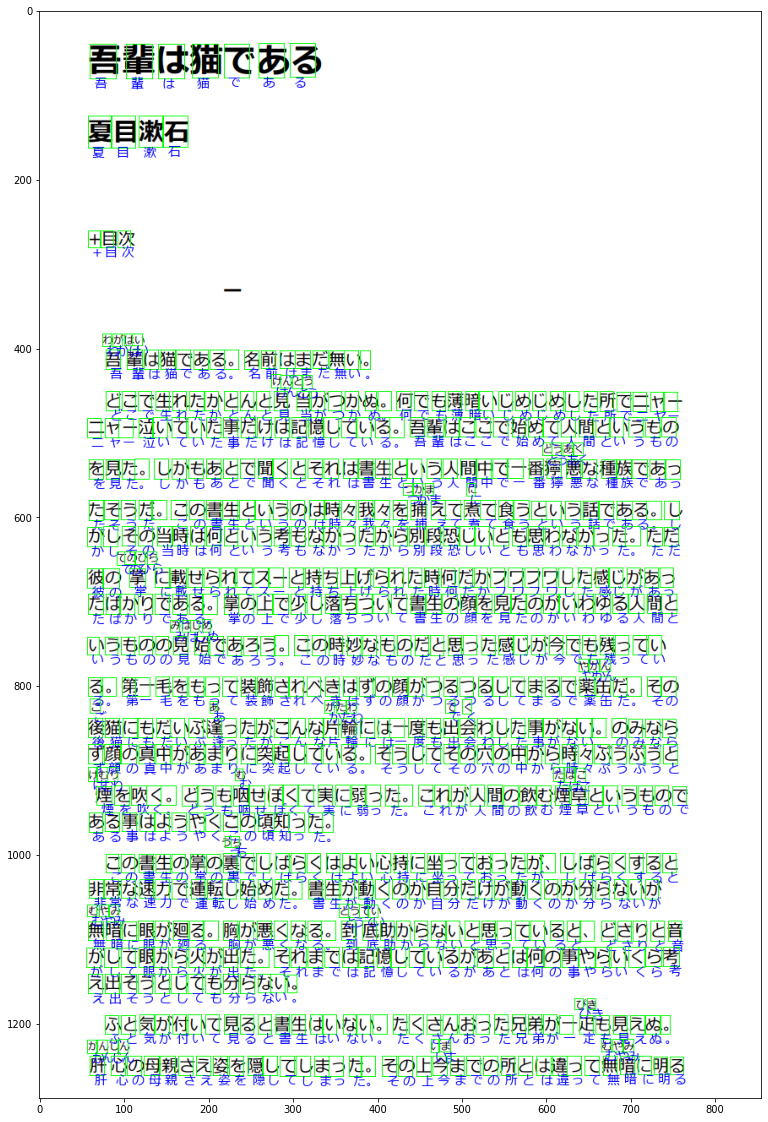

In [6]:
with open('./output_read3.2.json', 'r', encoding='utf-8') as f:
    analysis = json.load(f)
    
im = Image.open('./wagahaiwa_nekodearu.png')
draw = ImageDraw.Draw(im)
fnt = ImageFont.truetype('./meiryo.ttc', 15)

count = 0
polygons = []
if ("analyzeResult" in analysis):
    # 行ごとにデータを格納する
    lines = [(line["boundingBox"], line["text"], line["words"])
                for line in analysis["analyzeResult"]["readResults"][0]["lines"]]
    
    print("lines: ", len(lines))
    
    # 行レベル
    for line in lines:
        boundingBox = line[0]
        text = line[1]
        words = line[2]
        
        # 文字レベル
        for word in words:
            wp = word["boundingBox"]
            wtext = word["text"]
            wconfidence = word['confidence']
            
            #"boundingBox": [topleft_x, topleft_y, topright_x, topright_y, bottomright_x, bottomright_y, bottomleft_x, bottomleft_y]
            # 矩形を描画
            draw.rectangle([wp[0], wp[1], (wp[4], wp[5])], fill=None, outline=(0, 255, 0),  width=1)
            # テキストを描画
            draw.text((wp[6] + 5, wp[7] - 5), wtext, font=fnt, fill=(0, 0, 255))

plt.figure(figsize=(20, 20))
plt.imshow(np.array(im))

# 画像として出力
#im.save("./output_read3.2_word_result2.png")